### Problem Set 8
#### MACS 30150, Dr. Evans
#### Due Monday, Mar. 11 at 11:30am
#### Tianxin Zheng

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from scipy.stats import uniform as sp_uniform

#### 1. Decision trees

In [2]:
# load the data
data = pd.read_csv('biden.csv')
data.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


In [3]:
X = data[['female', 'age', 'educ', 'dem', 'rep']]
y = data.biden

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=25)

In [5]:
biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

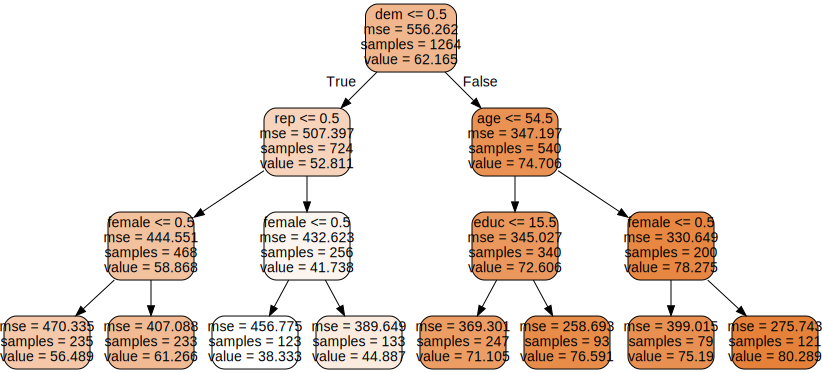

In [6]:
biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    feature_names=["female","age","educ","dem","rep"],
    class_names=data.biden,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

In [7]:
y_pred_1 = biden_tree.predict(X_test)
mse_1 = mean_squared_error(y_pred_1, y_test)
print('MSE = {}'.format(mse_1))

MSE = 396.1937146321307


#### (b)

In [8]:
param_dist1 = {'max_depth': [3, 10],
             'min_samples_split': sp_randint(2, 20),
             'min_samples_leaf': sp_randint(2, 20)}

In [41]:
biden_tree_2 = DecisionTreeRegressor()

random_search1 = \
    RandomizedSearchCV(biden_tree_2, param_distributions = param_dist1,
                       n_iter=100, n_jobs=-1, cv=5, random_state=25,
                       scoring='neg_mean_squared_error')

In [10]:
rs_fit1 = random_search1.fit(X_train, y_train)
print('RandBestEstimator1=', random_search1.best_estimator_)
print('RandBestParams1=', random_search1.best_params_)
print('RandBestScore1=', -random_search1.best_score_)

RandBestEstimator1= DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=9, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
RandBestParams1= {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 9}
RandBestScore1= 404.7488359884144


#### (c)

In [11]:
param_dist2 = {'n_estimators': [10, 200],
             'max_depth': [3, 10],
             'min_samples_split': sp_randint(2, 20),
             'min_samples_leaf': sp_randint(2, 20),
             'max_features': sp_randint(1, 5)}

In [12]:
random_forest = RandomForestRegressor()
random_search2 = RandomizedSearchCV(random_forest, param_distributions=param_dist2,
                                   n_iter=100, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')
rs_fit2 = random_search2.fit(X_train, y_train)

In [13]:
print('RandBestEstimator2 = ', rs_fit2)
print('RandBestParams2 = ', rs_fit2.best_params_)
print("MSE = ", abs(rs_fit2.best_score_))

RandBestEstimator2 =  RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 200], 'max_depth': [3, 10], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10b32c780>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10b32cd30>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10b32ccc0>},
          pre_dispatch='2*n_jobs', random_state=25, refit=True,
          return_train_score='warn', scoring='neg_mean_squa

#### 2. Classifier “horse” race

#### (a)

In [14]:
# load the data
df = pd.read_csv('Auto.csv', na_values='?')
df.columns=['mpg', 'cyl', 'displ', 'hpwr', 'wgt', 'accl', 'yr', 'orgn','name']
df['mpg_high'] = (df['mpg']>=df['mpg'].median()).astype('int')
df.dropna(inplace=True)
df_orgn = pd.get_dummies(df.orgn, prefix='orgn').iloc[:, :-1]
df = pd.concat([df, df_orgn], axis=1)
df.head()

,mpg,cyl,displ,hpwr,wgt,accl,yr,orgn,name,mpg_high,orgn_1,orgn_2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,1,0


In [15]:
k = 4
kf = KFold(k, shuffle=True, random_state=25)
Xvars = df[['cyl', 'displ', 'hpwr', 'wgt', 'accl', 'yr', 'orgn_1', 'orgn_2']].values
yvars = df.mpg_high.values
kf.get_n_splits(Xvars)
MSE_vec_kf = np.zeros(k)
y_test_lst2 = np.zeros(df.shape[0])
y_pred_lst2 = np.zeros(df.shape[0])

In [40]:
k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_test_lst2[test_index] = y_test
    y_pred_lst2[test_index] = y_pred
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
print('Test estimate MSE k-fold = {}.'.format(MSE_kf))
print(classification_report(y_test_lst2, y_pred_lst2))


MSE for test set 0  is 0.14285714285714285
MSE for test set 1  is 0.09183673469387756
MSE for test set 2  is 0.07142857142857142
MSE for test set 3  is 0.08163265306122448
Test estimate MSE k-fold = 0.09693877551020408.
             precision    recall  f1-score   support

        0.0       0.92      0.89      0.90       196
        1.0       0.89      0.92      0.90       196

avg / total       0.90      0.90      0.90       392



 The error rate for mpg_high=0 is 0.08. The error rate for mpg_high=1 is 0.11.

#### (b)

In [17]:
param_dist3 = {'n_estimators': [10, 200],
             'max_depth': [3, 8],
             'min_samples_split': sp_randint(2, 20),
             'min_samples_leaf': sp_randint(2, 20),
             'max_features': sp_randint(1, 8)}

In [18]:
random_forest2 = RandomForestClassifier()
param_dist3 = {'n_estimators': [10, 200],
                'max_depth': [3, 8],
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 8)}
random_search3 = RandomizedSearchCV(random_forest2, param_distributions=param_dist3,
                                   n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')
rs_fit3 = random_search3.fit(Xvars, yvars)

In [19]:
print('RandBestEstimator3 = ', rs_fit3)
print('RandBestParams3 = ', rs_fit3.best_params_)
print('MSE = ', abs(rs_fit3.best_score_))

RandBestEstimator3 =  RandomizedSearchCV(cv=4, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 200], 'max_depth': [3, 8], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10b31d4a8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10b418e80>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10b418f60>},
          pre_dispatch='2*n_jobs', random_state=25, refit=True,
          return_train

#### (c)

In [38]:
param_dist4 = {'C': sp_uniform(loc=0.2, scale=4.0),
               'shrinking': [True, False]}

In [39]:
svc = SVC(kernel='rbf')
random_search4 = RandomizedSearchCV(svc, param_distributions=param_dist4, n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')
rs_fit4 = random_search4.fit(Xvars, yvars)

In [37]:
print('RandBestEstimator3 = ', rs_fit4)
print('RandBestParams3 = ', rs_fit4.best_params_)
print('MSE = ', abs(rs_fit4.best_score_))

RandBestEstimator3 =  RandomizedSearchCV(cv=4, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10b38a2e8>, 'shrinking': [True, False]},
          pre_dispatch='2*n_jobs', random_state=25, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)
RandBestParams3 =  {'C': 0.49103170372176114, 'shrinking': False}
MSE =  0.461734693877551


#### (d)

The random forest predictor is the best predictor for mpg_high in terms of MSE.